In [292]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [293]:
# Read data in a list.
words = open('names.txt', 'r').read().splitlines()
print(f"Total amount of words: {len(words)}")

Total amount of words: 32033


In [294]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}

In [295]:
def plot_2d_characters(C: torch.tensor, size: int = 8) -> None:
    """
    Given a look-up table C of 2D character representations plot them on the grid.
    Args:
        C(torch.tensor, shape=[num_characters, 2]): Look-up table.
        size(int)                                 : Size of the plot.
    """
    vowels = ['a', 'e', 'i', 'o', 'u']  # list of all vowels in alphabet
    colors = ['red' if itos[ch] in vowels else 'blue' for ch in range(C.shape[0])]  # color vowels red
    colors[stoi['.']] = 'green'  # color '.' token green

    plt.figure(figsize=(size, size))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200, c=colors)
    for i in range(C.shape[0]):
        plt.text(C[i, 0].data, C[i, 1].data, itos[i], ha='center', va='center', color='white')
    plt.grid('minor')

In [296]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X).cuda(), torch.tensor(Y).cuda()
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

---

In [343]:
# Model's hyperparameters
chs_amt = len(stoi)             # characters amount (27)
repr_dim = 9                    # characters representation deimensions 
cnx_size = 4                    # contex_size / characters considered for prediction 
ipt_size = repr_dim * cnx_size  # input size of a single example
W1_ns = 250                     # Amount of neurons in the first layer
W2_ns = 300                     # Amount of neurons in the second layer

In [344]:
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

# Split data in Build, Development and Test sets.
Xtr, Ytr = build_dataset(words[:n1], cnx_size, True)
Xdev, Ydev = build_dataset(words[n1:n2], cnx_size, True)
Xte, Yte = build_dataset(words[n2:], cnx_size, True)

Input: torch.Size([182490, 4]), Output: torch.Size([182490])
Input: torch.Size([22807, 4]), Output: torch.Size([22807])
Input: torch.Size([22849, 4]), Output: torch.Size([22849])


In [345]:
# Initialize model
g = torch.Generator().manual_seed(13)
C = torch.randn(size=[chs_amt, repr_dim], generator=g).cuda()
W1 = torch.randn([ipt_size, W1_ns], generator=g).cuda()
b1 = torch.randn([W1_ns], generator=g).cuda()

W2 = torch.randn([W1_ns, W2_ns], generator=g).cuda() 
b2 = torch.randn([W2_ns], generator=g).cuda()

W3 = torch.randn([W2_ns, chs_amt], generator=g).cuda() 
b3 = torch.randn([chs_amt], generator=g).cuda()

parameters = [C, W1, b1, W2, b2, W3, b3]
tot_prms = sum(p.nelement() for p in parameters)  # total amount of parameters in a model
# Tell torch to compute gradients for created parameters.
for p in parameters:
    p.requires_grad = True
print(tot_prms)
[p.shape for p in parameters]

92920


[torch.Size([27, 9]),
 torch.Size([36, 250]),
 torch.Size([250]),
 torch.Size([250, 300]),
 torch.Size([300]),
 torch.Size([300, 27]),
 torch.Size([27])]

In [346]:
"""Requires model and C-table initialization! Modifies global parameters!"""
def forward_pass(ipt_exmps: torch.tensor, tgt_exmps: torch.tensor) -> torch.tensor:
    """
    Given input parameters, input and target examples performs a forward pass and returns loss.
    Args:
        ipt_exmps(torch.tensor, shape=[m, ipt_size]): Input tensor, m - number of examples.
        tgt_exmps(torch.tensor, shape=[m])          : Target tensor, m - number of examples.
    Returns:
        loss(torch.tensor): evaluated loss.
    """
    emb = C[ipt_exmps]
    out1 = torch.tanh(emb.view(-1, ipt_size) @ W1 + b1)
    out2 = torch.tanh(out1 @ W2 + b2)
    logits = out2 @ W3 + b3
    loss = F.cross_entropy(logits, tgt_exmps)
    return loss

In [347]:
# Place for tracking:
lri = []
lossi = []
stepi = []

usteps = []
trlosses = []
devlosses = []

In [348]:
# Learning hyperparameters
iters_num = 200000                  # number of iterations
lr = 0.3                     # learning rate
batch_size = 512               # size of the mini-batch
log_loss_step = False          # pring loss at each gradient step
upd_step = 3000
log_upd = True        

In [349]:
for i in range(iters_num):
    if (i+1) % upd_step == 0:
        lr *= 0.9
        # Limit learning rate decrease
        if lr < 0.0001:
            lr = 0.0001

        batch_size = int(batch_size*1.02)
        # Limit batch size growth
        if batch_size > 1024:
            batch_size = 1024

        trloss = forward_pass(Xtr, Ytr)
        devloss = forward_pass(Xdev, Ydev)
        trlosses.append(trloss)
        devlosses.append(devloss)
        usteps.append(i)
        if log_upd:
            print(f'{i=} | {lr=:0.5f} | {batch_size=} | {trloss=:0.5f} | {devloss=:0.5f}')
    
    """Mini-batch construct"""
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    """Forward pass"""
    loss = forward_pass(Xtr[ix], Ytr[ix])
    if log_loss_step:
        print(loss.item())
    
    """Backward pass"""
    for p in parameters:
        p.grad = None
    loss.backward()
    
    """Update"""
    for p in parameters:
        p.data += -lr * p.grad
    
    """Track stats"""
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)


i=2999 | lr=0.27000 | batch_size=522 | trloss=4.07605 | devloss=4.18892
i=5999 | lr=0.24300 | batch_size=532 | trloss=3.67418 | devloss=3.81899
i=8999 | lr=0.21870 | batch_size=542 | trloss=2.72758 | devloss=2.88935
i=11999 | lr=0.19683 | batch_size=552 | trloss=2.69192 | devloss=2.87046
i=14999 | lr=0.17715 | batch_size=563 | trloss=2.21515 | devloss=2.41138
i=17999 | lr=0.15943 | batch_size=574 | trloss=2.28702 | devloss=2.48809
i=20999 | lr=0.14349 | batch_size=585 | trloss=2.14284 | devloss=2.34848
i=23999 | lr=0.12914 | batch_size=596 | trloss=2.14557 | devloss=2.35760
i=26999 | lr=0.11623 | batch_size=607 | trloss=2.13640 | devloss=2.35113
i=29999 | lr=0.10460 | batch_size=619 | trloss=2.10952 | devloss=2.32339
i=32999 | lr=0.09414 | batch_size=631 | trloss=2.08955 | devloss=2.30829
i=35999 | lr=0.08473 | batch_size=643 | trloss=2.07257 | devloss=2.29430
i=38999 | lr=0.07626 | batch_size=655 | trloss=2.06537 | devloss=2.28990
i=41999 | lr=0.06863 | batch_size=668 | trloss=2.05913

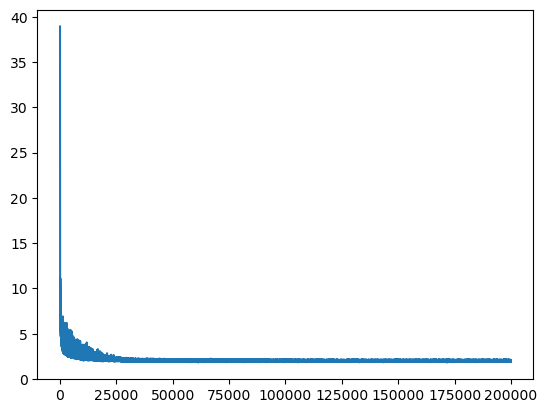

In [352]:
plt.plot(stepi, lossi)

In [353]:
train_loss = forward_pass(Xtr, Ytr)
dev_loss = forward_pass(Xdev, Ydev)
print(f"train: {train_loss}\ndevop: {dev_loss}")

train: 2.0165367126464844
devop: 2.2611048221588135


66 66


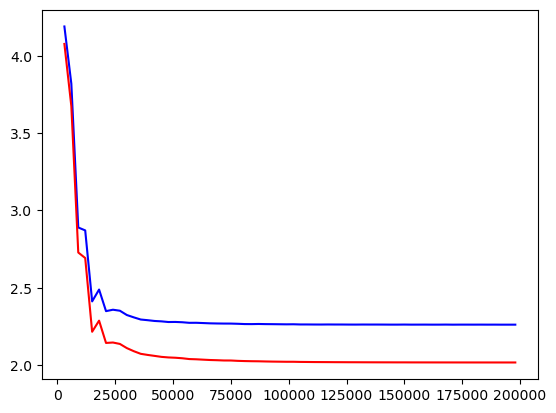

In [354]:
print(len(devlosses), len(trlosses))
plt.plot(usteps, [loss.item() for loss in devlosses], c='blue')
plt.plot(usteps, [loss.item() for loss in trlosses], c='red')

In [405]:
# Sampling from the model!
cudag = torch.Generator(device='cuda').manual_seed(13)
samples = []
num_samples = 100
for i in range(num_samples):
    context = [0] * cnx_size
    sample = ''
    while True:
        x = C[context].view(-1, cnx_size * repr_dim)
        out1 = torch.tanh(x @ W1 + b1)
        out2 = torch.tanh(out1 @ W2 + b2)
        logits = out2 @ W3 + b3
        counts = torch.exp(logits)
        probs = counts / torch.sum(counts)
        guess = torch.multinomial(probs, 1, True, generator=cudag).item()
        sample += itos[guess]
        context = context[1:] + [guess]
        if guess == 0:
            break
    samples.append(sample[:-1])

samples


['moan',
 'naiden',
 'colay',
 'emmilo',
 'grontae',
 'zeniih',
 'bowkuureh',
 'ambor',
 'dhoyk',
 'rhy',
 'lozamvortoos',
 'calal',
 'rerismoni',
 'zanobia',
 'anton',
 'maksil',
 'itha',
 'ujuy',
 'inia',
 'neinah',
 'jelaiah',
 'janine',
 'jaynie',
 'frer',
 'fryc',
 'ayri',
 'phan',
 'eryal',
 'papi',
 'dada',
 'jeiina',
 'aung',
 'carhavi',
 'ryytrahamira',
 'raryiah',
 'arma',
 'hlakii',
 'yahahrol',
 'lyne',
 'kayghvika',
 'pashalipiji',
 'aver',
 'aved',
 'nyas',
 'sosroas',
 'sivion',
 'sesealo',
 'darelyn',
 'ayran',
 'giag',
 'nalvin',
 'jickeeni',
 'lora',
 'iviya',
 'tinley',
 'mirco',
 'ayra',
 'lura',
 'amalodreru',
 'merius',
 'chombree',
 'adariono',
 'olipalla',
 'cosemissak',
 'hana',
 'sela',
 'zona',
 'brea',
 'taka',
 'anna',
 'ometana',
 'mamad',
 'aviley',
 'anasea',
 'raylinna',
 'mamoor',
 'tracianna',
 'almare',
 'fryleenye',
 'ayhca',
 'ammiy',
 'thoytendi',
 'tweilemeni',
 'kaeeh',
 'jadiso',
 'keyven',
 'amai',
 'kaqonillawyn',
 'arnin',
 'maanang',
 'kyha